## Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Загрузим датасет из sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [153]:
a = {"sepal_length":X[:,0:1].ravel(),"sepal width":X[:,1:2].ravel(),"petal length":X[:,2:3].ravel(),"petal width":X[:,3:4].ravel()}
b = pd.DataFrame(a)

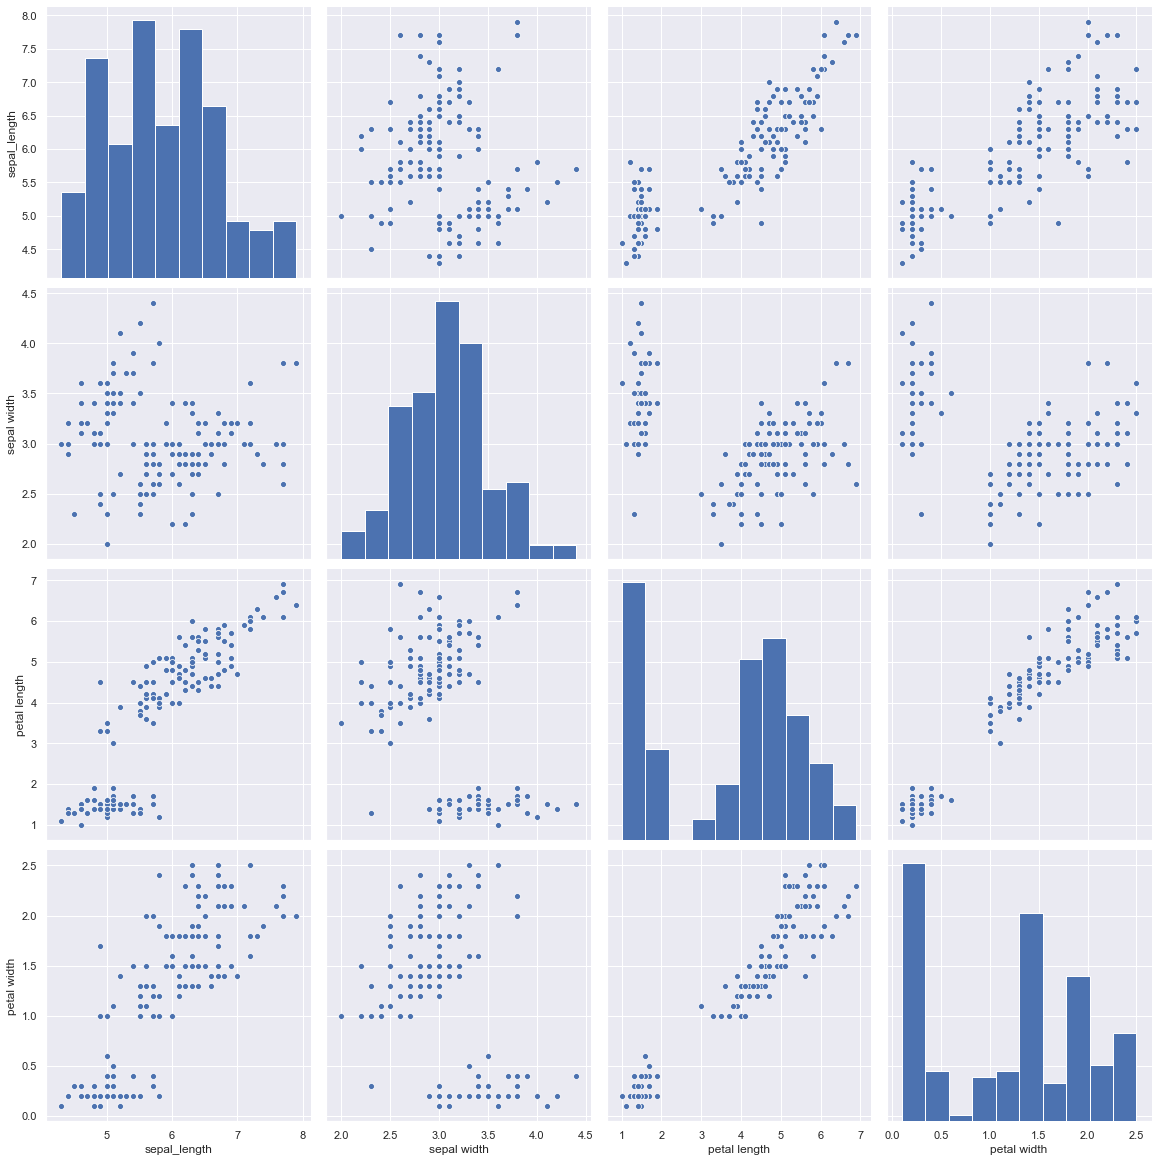

In [107]:
sns.pairplot(b, height=4);

### Матрица корреляций

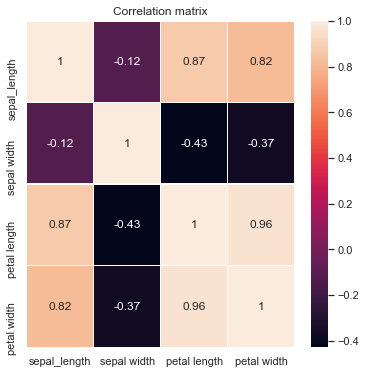

In [113]:
plt.figure(figsize = (6,6))

sns.set(font_scale=1)
sns.heatmap(b.corr(), annot=True, linewidths=.5)

plt.title('Correlation matrix');

In [154]:
clf = RandomForestClassifier(max_depth=3, n_estimators=5)
clf.fit(X_train, y_train)
accuracy_valid = accuracy_score(y_valid, clf.predict(X_valid))
accuracy_train = accuracy_score(y_train, clf.predict(X_train))
print(f'accuracy На тестовой выборке {accuracy_valid} ')
print(f'accuracy На train выборке {accuracy_train} ')

accuracy На тестовой выборке 0.9736842105263158 
accuracy На train выборке 0.9464285714285714 


In [155]:
def standard_scale(x):
    x = x.astype(float)
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

### Уменьшим размерность признаков

In [156]:
# Для начала отмасштабируем выборку
X = standard_scale(X)

In [157]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.77467247979865, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.1045707202106, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.013531335697223, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.1072254642929384, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [158]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.850761786701792, 3.6689218892828745, 0.5178709107154903]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [159]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [160]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

### Обучим повторно модель и сравним качество классификации по отложенной выборке

In [161]:
X = Z
y = iris.target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [165]:
clf = RandomForestClassifier(max_depth=3, n_estimators=5)
clf.fit(X_train, y_train)
accuracy_valid = accuracy_score(y_valid, clf.predict(X_valid))
accuracy_train = accuracy_score(y_train, clf.predict(X_train))
print(f'accuracy На тестовой выборке {accuracy_valid} ')
print(f'accuracy На train выборке {accuracy_train} ')

accuracy На тестовой выборке 0.9210526315789473 
accuracy На train выборке 0.9285714285714286 


### При 2х кратным уменьшением количества признаков, качество на отложенной выборке уменьшилось на 3% от 96%, что можно считать незначительным, .

In [166]:
iris = datasets.load_iris()
X = iris.data
X = standard_scale(X)

Найдем сингулярное разложение вектора $X$, где столбцы ортогональной матрицы $U$ - это собственные векторы матрицы $XX^{T}$, столбцы ортогональной матрицы $V$ - собственные векторы матрицы $X^{T}X$, а на главной диагонали диагональной матрицы $D$ расположены собственные значения матриц $XX^{T}$ и $X^{T}X$ (они равны и также называются сингулярными числами матрицы $X$).

In [167]:
𝑈,D,V = np.linalg.svd(X)

V = V.T

Наибольшими сингулярным числами являются 20.92 и 11.07

In [168]:
D

array([20.92306556, 11.7091661 ,  4.69185798,  1.76273239])

Сформируем из столбцов матрицы  𝑉 , соответствующих  𝑑  наибольшим сингулярным числам, матрицу весов  𝑊

In [169]:
W = V[:,:2]
W

array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

Получии новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

In [170]:
Z = X@W

In [171]:
X = Z
y = iris.target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
clf = RandomForestClassifier(max_depth=3, n_estimators=20)

In [174]:

clf.fit(X_train, y_train)
accuracy_valid = accuracy_score(y_valid, clf.predict(X_valid))
accuracy_train = accuracy_score(y_train, clf.predict(X_train))
print(f'accuracy На тестовой выборке {accuracy_valid} ')
print(f'accuracy На train выборке {accuracy_train} ')

accuracy На тестовой выборке 0.9210526315789473 
accuracy На train выборке 0.9285714285714286 


### Accuracy модели на тестовой выборке, обученной с уменьшением признаков по методу главных компонент совпадает с accuracy модели обученной с уменьшением признаков использовав сингулярное разложением матриц.  